In [1]:
from temporal_networkx import TemporalDiGraph
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import seaborn as sb
from datetime import datetime, timedelta
from copy import deepcopy

In [2]:
temporal_graph = TemporalDiGraph(pd.read_csv('./soc-sign-bitcoinotc.csv', header=None))

# Simulation of Banning Users

## Preparation of Methods

First, snapshots of the directed graph for the whole dataset is saved for comparison during simulation.

In [11]:
first_month = str(temporal_graph.get_all_months()[0])
end_month = str(temporal_graph.get_all_months()[-1])

In [93]:
baseline_graph = deepcopy(monthly_baseline_graphs[end_month])

### Banning a Single User

The parameters of the method are:
* node_id (int) - Node ID of the user in the dataset.
* ban_month (str) - Month when the user is banned (after the month has ended), in YYYY-MM format.
* rating_threshold (float) - Any rating below this threshold would be considered as a bad rating. Defaults to 0.0.
* fairness_threshold (float) - Any edge fairness below this threshold would be considered as a biased rating. Defaults to 0.0.
* verbose (bool) - Whether the simulation is run verbosely.

The method returns a dictionary with the following information:
* Final goodness score of the user
* Final average rating of the user
* Rating, fairness and count of the in-edges and out-edges of the user in the future

Unit test of the method:

In [106]:
def ban_user(user_to_be_banned: int, ban_month: str,
             rating_threshold: float=0.0,
             fairness_threshold: float=0.0,
             verbose: bool=False):
    future_of_the_user = {
        'node_id': user_to_be_banned,
        'final_goodness': monthly_baseline_graphs[end_month].nodes[user_to_be_banned]['goodness'],
        'final_average_rating': monthly_baseline_graphs[end_month].nodes[user_to_be_banned]['average_rating'],
        'future_in_edges': [],
        'future_out_edges': [],
        'bad_in_edges': 0,
        'good_in_edges': 0,
        'fair_bad_in_edges': 0,
        'fair_good_in_edges': 0,
        'bias_bad_in_edges': 0,
        'bias_good_in_edges': 0,
        'bad_out_edges': 0,
        'good_out_edges': 0,
        'fair_bad_out_edges': 0,
        'fair_good_out_edges': 0,
        'bias_bad_out_edges': 0,
        'bias_good_out_edges': 0
    }

    # Find out all edges of this user AFTER ban_month
    # (simulating users being banned at the end of each month)
    ban_month_dt = datetime.strptime(ban_month, '%Y-%m')
    ban_month_dt = ban_month_dt.replace(day=1, hour=0, minute=0, second=0, microsecond=0)
    next_month_dt = ban_month_dt + timedelta(days=31)
    next_month_dt = ban_month_dt.replace(day=1, hour=0, minute=0, second=0, microsecond=0)

    # Find out all in-edges of the user in this month
    for edge in baseline_graph.in_edges(user_to_be_banned, data=True):
        if edge[2]['time'] >= next_month_dt:
            if edge[2]['weight'] < rating_threshold:
                future_of_the_user['bad_in_edges'] = future_of_the_user['bad_in_edges'] + 1

                if edge[2]['fairness'] < fairness_threshold:
                    future_of_the_user['bias_bad_in_edges'] = future_of_the_user['bias_bad_in_edges'] + 1
                else:
                    future_of_the_user['fair_bad_in_edges'] = future_of_the_user['fair_bad_in_edges'] + 1
            else:
                future_of_the_user['good_in_edges'] = future_of_the_user['good_in_edges'] + 1

                if edge[2]['fairness'] < fairness_threshold:
                    future_of_the_user['bias_good_in_edges'] = future_of_the_user['bias_good_in_edges'] + 1
                else:
                    future_of_the_user['fair_good_in_edges'] = future_of_the_user['fair_good_in_edges'] + 1

            edge_item = {
                'weight': edge[2]['weight'],
                'fairness': edge[2]['fairness']
            }
            future_of_the_user['future_in_edges'].append(edge_item)

    for edge in baseline_graph.out_edges(user_to_be_banned, data=True):
        if edge[2]['time'] >= next_month_dt:
            if edge[2]['weight'] < rating_threshold:
                future_of_the_user['bad_out_edges'] = future_of_the_user['bad_out_edges'] + 1

                if edge[2]['fairness'] < fairness_threshold:
                    future_of_the_user['bias_bad_out_edges'] = future_of_the_user['bias_bad_out_edges'] + 1
                else:
                    future_of_the_user['fair_bad_out_edges'] = future_of_the_user['fair_bad_out_edges'] + 1
            else:
                future_of_the_user['good_out_edges'] = future_of_the_user['good_out_edges'] + 1

                if edge[2]['fairness'] < fairness_threshold:
                    future_of_the_user['bias_good_out_edges'] = future_of_the_user['bias_good_out_edges'] + 1
                else:
                    future_of_the_user['fair_good_out_edges'] = future_of_the_user['fair_good_out_edges'] + 1

            edge_item = {
                'weight': edge[2]['weight'],
                'fairness': edge[2]['fairness']
            }
            future_of_the_user['future_out_edges'].append(edge_item)
        
    if verbose:
        print(f"At end of the baseline dataset, the {user_to_be_banned} had a final average rating of {future_of_the_user['final_average_rating']}, and final goodness score of {future_of_the_user['final_goodness']}.")

        print(f"Banning the user would have prevent {future_of_the_user['bad_in_edges']} bad in-edges ({future_of_the_user['fair_bad_in_edges']} fair, {future_of_the_user['bias_bad_in_edges']} biased) and {future_of_the_user['good_in_edges']} good in-edges ({future_of_the_user['fair_good_in_edges']} fair, {future_of_the_user['bias_good_in_edges']} biased),")

        print(f"and {future_of_the_user['bad_out_edges']} bad out-edges ({future_of_the_user['fair_bad_out_edges']} fair, {future_of_the_user['bias_bad_out_edges']} biased) and {future_of_the_user['good_out_edges']} good out-edges ({future_of_the_user['fair_good_out_edges']} fair, {future_of_the_user['bias_good_out_edges']} biased).")
    
    return future_of_the_user

In [103]:
result = ban_user(103, '2011-05', 0.0, 0.0, True)

At end of the baseline dataset, the 103 had a final average rating of 1.0, and final goodness score of 0.6346669696017236.
Banning the user would have prevent 0 bad in-edges (0 fair, 0 biased) and 0 good in-edges (0 fair, 0 biased),
and 0 bad out-edges (0 fair, 0 biased) and 0 good out-edges (0 fair, 0 biased).


In [107]:
result = ban_user(179, '2011-03', 0.0, 0.0, True)

At end of the baseline dataset, the 179 had a final average rating of -0.42857142857142855, and final goodness score of -0.11512300644992719.
Banning the user would have prevent 5 bad in-edges (5 fair, 0 biased) and 1 good in-edges (1 fair, 0 biased),
and 0 bad out-edges (0 fair, 0 biased) and 1 good out-edges (1 fair, 0 biased).


### Banning Bad Users at the End of Each Month

After defining the method to simulate the effect of banning one user, the following method finds out bad users at the end of each month of the dataset, and simulates the effects of banning the bad users.

The parameters of this method are:
* criterion (str): Can be 'goodness' meaning to REV2 goodness score to find out bad users, or 'average' or 'average_rating' meaning to use average rating to find out bad users.
* threshold (float): Users having goodness score OR average rating below this threshold would be considered as bad users, and simulation would run on these users.
* verbose (bool): Whether this method should be run verbosely.
* verbose_ban_user (bool): Whether the simulation of banning individual users should be run verbosely. Default to False.

The method would return the following pd.DataFrame objects:
* users_banned_average_df - The final goodness score and average rating of the users being banned.
* in_edges_removed_df - Rating and fairness of the in-edges that would have been prevented as a result of users being banned.
* out_edges_removed_df- Rating and fairness of the out-edges that would have been prevented as a result of users being banned.

In [119]:
def simulation(criterion: str, threshold: float, verbose: bool, verbose_ban_user: bool=False):

    if criterion not in ['goodness', 'average', 'average_rating']:
        raise RuntimeError("criterion should be either 'goodness' or 'average', 'average_rating'")
    
    run_REV2 = False
    calc_avg = False

    if criterion == 'goodness':
        run_REV2 = True

    if criterion == 'average' or criterion == 'average_rating':
        calc_avg = True
        criterion = 'average_rating'

    sep = '---------------------------------------------------------------------------'

    # a list storing banned users in form of tuples:
    #   (month, user_id, final_goodness, final_average_rating)
    users_banned = []

    # a list storing removed in-edges in form of tuples
    #   (month, rating, fairness)
    in_edges_removed = []

    # a list storing removed out-edges in form of tuples
    #   (month, rating, fairness)
    out_edges_removed = []


    if verbose:
        print(f'Running simulation of banning users based on {criterion} with threshold of {threshold}')
        print(sep)

    # Loop thru all rolling months
    for month in temporal_graph.get_all_months():
        month = str(month)

        if verbose:
            print(f'Simulating for the month {month}')

        simulation_graph = deepcopy(temporal_graph)
        
        # Remove users that were already banned from simulation_graph
        months_banned = set([ rec[0] for rec in users_banned ])
        for k in months_banned:
            if k < month:
                # Only drop the in-edges from the current month
                banned_users = [-1, -2] + [ rec[1] for rec in users_banned if rec[0] == k ]
                simulation_graph.df = simulation_graph.df.drop(
                    simulation_graph.df[simulation_graph.df.index > k]
                    .query(f"target in ({','.join([str(x) for x in banned_users])})").index
                )
                simulation_graph.df = simulation_graph.df.drop(
                    simulation_graph.df[simulation_graph.df.index > k]
                    .query(f"source in ({','.join([str(x) for x in banned_users])})").index
                )
        G = simulation_graph.get_DiGraph(first_month, month, run_REV2=run_REV2, calc_average=calc_avg)
        # Find out bad users
        bad_users = [node[0] for node in G.nodes(data=True) if node[1][criterion] is not None and node[1][criterion] < threshold]

        
        for k in months_banned:
            if k < month:
                users_banned_this_month = [rec[1] for rec in users_banned if rec[0] == k]
                if len(users_banned_this_month) > 0:
                    bad_users = [b for b in bad_users if b not in users_banned_this_month]

        if verbose:
            print('Effects of banning users in this month:')
            print(f"{len(bad_users)} bad user(s) were banned")

        future_changed = False
        for bad_user in bad_users:
            future_changed = True
            results = ban_user(bad_user, month, 0, 0, verbose_ban_user)

            # added record to user_banned (month, user_id, final_goodness, final_average_rating)
            item = (month, results['node_id'], results['final_goodness'], results['final_average_rating'])
            users_banned.append(item)

            # add records to in_edges_removed (month, rating, fairness)
            for in_edge in results['future_in_edges']:
                item = (month, in_edge['weight'], in_edge['fairness'])
                in_edges_removed.append(item)

            # add records to out_edges_removed (month, rating, fairness)
            for out_edge in results['future_out_edges']:
                item = (month, out_edge['weight'], out_edge['fairness'])
                out_edges_removed.append(item)

        if verbose:
            if future_changed:
                this_month_bad_users = 0
                this_month_good_users = 0
                if criterion == 'goodness':
                    this_month_bad_users = [ 1 for rec in users_banned if rec[0] == month and rec[2] < threshold ]
                    this_month_good_users = [ 1 for rec in users_banned if rec[0] == month and rec[2] >= threshold ]
                else:
                    this_month_bad_users = [ 1 for rec in users_banned if rec[0] == month and rec[3] < threshold ]
                    this_month_good_users = [ 1 for rec in users_banned if rec[0] == month and rec[3] >= threshold ]

                this_month_bad_users = len(this_month_bad_users)
                this_month_good_users = len(this_month_good_users)

                print('Final scores/ratings of banned users in this month:')
                print(f'{this_month_bad_users} users would have had final {criterion} < {threshold}')
                print(f'{this_month_good_users} users would have had final {criterion} >= {threshold}')

                num_in_edges = len([1 for rec in in_edges_removed if rec[0] == month])
                num_bad_in_edges = len([1 for rec in in_edges_removed if rec[0] == month and rec[1] < 0])
                num_good_in_edges = len([1 for rec in in_edges_removed if rec[0] == month and rec[1] > 0])

                print('\n')
                print(f'{num_in_edges} in-edge(s) would have been prevented:')
                print(f'{num_bad_in_edges} bad rating(s), {num_good_in_edges} good rating(s)')

                num_out_edges = len([1 for rec in out_edges_removed if rec[0] == month])
                num_bad_out_edges = len([1 for rec in out_edges_removed if rec[0] == month and rec[1] < 0])
                num_good_out_edges = len([1 for rec in out_edges_removed if rec[0] == month and rec[1] > 0])

                print('\n')
                print(f'{num_out_edges} out-edge(s) would have been prevented:')
                print(f'{num_bad_out_edges} bad rating(s), {num_good_out_edges} good rating(s)')
            else:
                print('Simulation of this month would not have affected the future')
            print(sep)
    
    if verbose:
        print('Final simulation results:')
        num_bad_users = 0
        num_good_users = 0
        if criterion == 'goodness':
            num_bad_users = [ 1 for rec in users_banned if rec[2] < threshold ]
            num_good_users = [ 1 for rec in users_banned if rec[2] >= threshold ]
        else:
            num_bad_users = [ 1 for rec in users_banned if rec[3] < threshold ]
            num_good_users = [ 1 for rec in users_banned if rec[3] >= threshold ]

        num_bad_users = len(num_bad_users)
        num_good_users = len(num_good_users)

        print('Final scores/ratings of banned users:')
        print(f'{num_bad_users} users would have had final {criterion} < {threshold}')
        print(f'{num_good_users} users would have had final {criterion} >= {threshold}')

        num_in_edges = len(in_edges_removed)
        num_bad_in_edges = len([1 for rec in in_edges_removed if rec[1] < 0])
        num_good_in_edges = len([1 for rec in in_edges_removed if rec[1] > 0])

        print('\n')
        print(f'{num_in_edges} in-edge(s) would have been prevented:')
        print(f'{num_bad_in_edges} bad rating(s), {num_good_in_edges} good rating(s)')

        num_out_edges = len(out_edges_removed)
        num_bad_out_edges = len([1 for rec in out_edges_removed if rec[1] < 0])
        num_fair_bad_out_edges = len([1 for rec in out_edges_removed if rec[1] < 0 and rec[2] >= 0])
        num_bias_bad_out_edges = len([1 for rec in out_edges_removed if rec[1] < 0 and rec[2] < 0])
        num_good_out_edges = len([1 for rec in out_edges_removed if rec[1] > 0])
        num_fair_good_out_edges = len([1 for rec in out_edges_removed if rec[1] > 0 and rec[2] >= 0])
        num_bias_good_out_edges = len([1 for rec in out_edges_removed if rec[1] > 0 and rec[2] < 0])

        print('\n')
        print(f'{num_out_edges} out-edge(s) would have been prevented:')
        print(f'{num_bad_out_edges} bad rating(s), {num_good_out_edges} good rating(s)')

    users_banned_average_df = pd.DataFrame.from_records(
        users_banned_average,
        columns=['month', 'node_id', 'final_goodness', 'final_average_rating'])

    in_edges_removed_df = pd.DataFrame.from_records(
        in_edges_removed,
        columns=['month', 'rating', 'fairness']
    )

    out_edges_removed_df = pd.DataFrame.from_records(
        out_edges_removed,
        columns=['month', 'rating', 'fairness']
    )

    return users_banned_average_df, in_edges_removed_df, out_edges_removed_df

## Simulations

### Simulation Using Average Ratings

In [120]:
users_banned_average, in_edges_removed_average, out_edges_removed_average = simulation('average', 0, True)

Running simulation of banning users based on average_rating with threshold of 0
---------------------------------------------------------------------------
Simulating for the month 2010-11
Effects of banning users in this month:
0 bad user(s) were banned
Simulation of this month would not have affected the future
---------------------------------------------------------------------------
Simulating for the month 2010-12
Effects of banning users in this month:
0 bad user(s) were banned
Simulation of this month would not have affected the future
---------------------------------------------------------------------------
Simulating for the month 2011-01
Effects of banning users in this month:
0 bad user(s) were banned
Simulation of this month would not have affected the future
---------------------------------------------------------------------------
Simulating for the month 2011-02
Effects of banning users in this month:
0 bad user(s) were banned
Simulation of this month would not have 

In [203]:
users_banned_average.to_csv('users_banned_average.csv')
in_edges_removed_average.to_csv('in_edges_removed_average.csv')
out_edges_removed_average.to_csv('out_edges_removed_average.csv')

### Simulation Using Goodness Scores

In [116]:
users_banned_goodness, in_edges_removed_goodness, out_edges_removed_goodness = simulation('goodness', 0, True)

Running simulation of banning users based on goodness with threshold of 0
---------------------------------------------------------------------------
Simulating for the month 2010-11
Effects of banning users in this month:
0 bad user(s) were banned
Simulation of this month would not have affected the future
---------------------------------------------------------------------------
Simulating for the month 2010-12
Effects of banning users in this month:
0 bad user(s) were banned
Simulation of this month would not have affected the future
---------------------------------------------------------------------------
Simulating for the month 2011-01
Effects of banning users in this month:
0 bad user(s) were banned
Simulation of this month would not have affected the future
---------------------------------------------------------------------------
Simulating for the month 2011-02
Effects of banning users in this month:
0 bad user(s) were banned
Simulation of this month would not have affect

In [204]:
users_banned_goodness.to_csv('users_banned_goodness.csv')
in_edges_removed_goodness.to_csv('in_edges_removed_goodness.csv')
out_edges_removed_goodness.to_csv('out_edges_removed_goodness.csv')

## Results

In [130]:
sb.set_style('darkgrid')

First, the new columns are added to ```users_banned_goodness``` and ```users_banned_average``` to indicate whether the users had a final score/average rating below or above threshold.

In [179]:
users_banned_goodness['type_rating'] = users_banned_goodness.apply(lambda row:
    'bad' if row['final_average_rating'] < 0 else 'good',
    axis=1
)
users_banned_goodness['type_goodness'] = users_banned_goodness.apply(lambda row:
    'bad' if row['final_goodness'] < 0 else 'good',
    axis=1
)

In [186]:
users_banned_average['type_rating'] = users_banned_average.apply(lambda row:
    'bad' if row['final_average_rating'] < 0 else 'good',
    axis=1
)
users_banned_average['type_goodness'] = users_banned_average.apply(lambda row:
    'bad' if row['final_goodness'] < 0 else 'good',
    axis=1
)

### Final Goodness Scores of the Users 

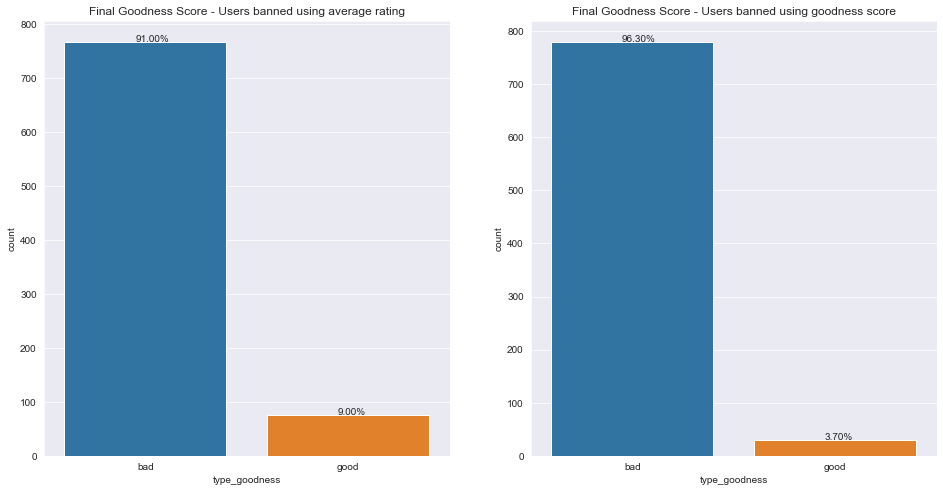

In [197]:
plt.figure(figsize=(16, 8))

num_bad = (len(users_banned_average[users_banned_average['type_goodness'] == 'bad']) / len(users_banned_average['type_goodness']))*100
num_good = (len(users_banned_average[users_banned_average['type_goodness'] == 'good']) / len(users_banned_average['type_goodness']))*100
pct_bad = '{:.2f}%'.format(num_bad)
pct_good = '{:.2f}%'.format(num_good)

col_labels = [pct_bad, pct_good]
plt.subplot(121)
ax = sb.countplot(data=users_banned_average,
                  x='type_goodness',
                  order=users_banned_average['type_goodness'].value_counts().index)

for p, label in zip(ax.patches, col_labels):
     ax.annotate(label, (p.get_x()+0.35, p.get_height()+0.5))

plt.title('Final Goodness Score - Users banned using average rating')


num_bad = (len(users_banned_goodness[users_banned_goodness['type_goodness'] == 'bad']) / len(users_banned_goodness['type_goodness']))*100
num_good = (len(users_banned_goodness[users_banned_goodness['type_goodness'] == 'good']) / len(users_banned_goodness['type_goodness']))*100
pct_bad = '{:.2f}%'.format(num_bad)
pct_good = '{:.2f}%'.format(num_good)

col_labels = [pct_bad_goodness, pct_good_goodness]
plt.subplot(122)
ax = sb.countplot(data=users_banned_goodness,
                  x='type_goodness',
                  order=users_banned_goodness['type_goodness'].value_counts().index)

for p, label in zip(ax.patches, col_labels):
     ax.annotate(label, (p.get_x()+0.35, p.get_height()+0.5))

plt.title('Final Goodness Score - Users banned using goodness score')
plt.show()

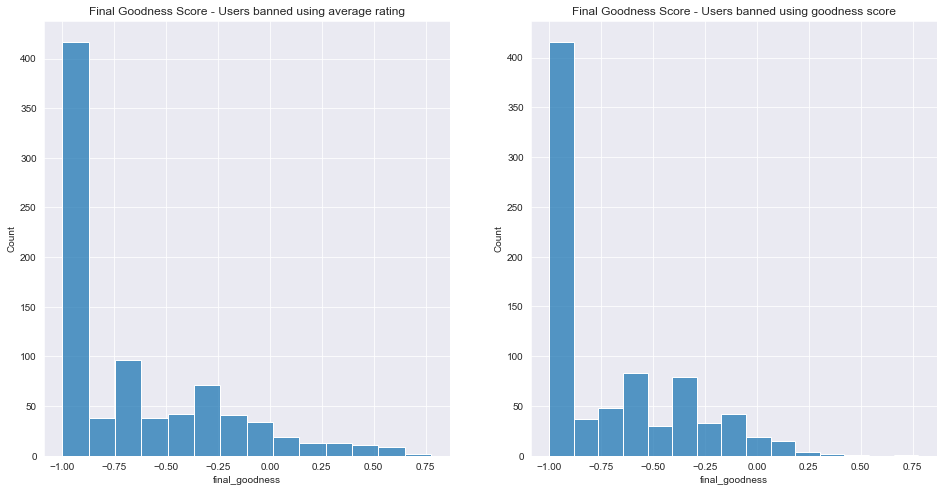

In [201]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
sb.histplot(data=users_banned_average,x='final_goodness')
plt.title('Final Goodness Score - Users banned using average rating')
plt.subplot(122)
sb.histplot(data=users_banned_goodness, x='final_goodness')
plt.title('Final Goodness Score - Users banned using goodness score')
plt.show()

### Final Average Ratings of the Users

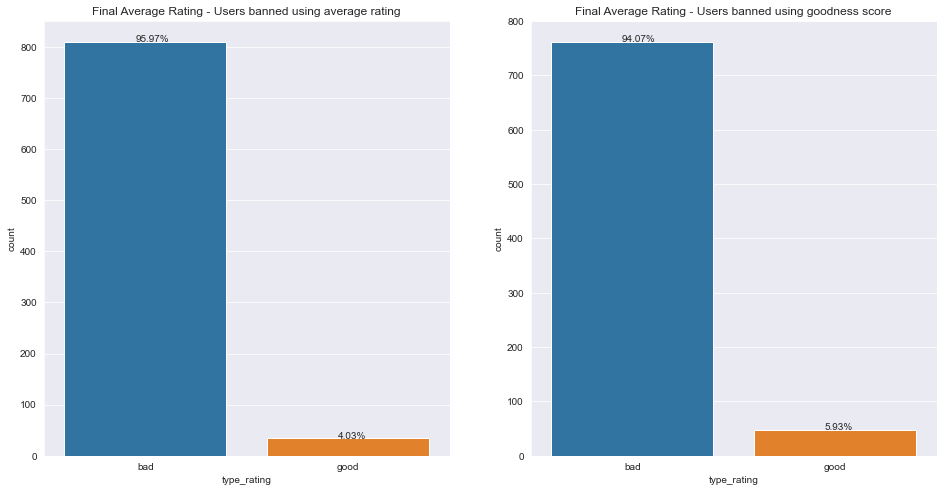

In [194]:
plt.figure(figsize=(16, 8))

num_bad = (len(users_banned_average[users_banned_average['type_rating'] == 'bad']) / len(users_banned_average['type_rating']))*100
num_good = (len(users_banned_average[users_banned_average['type_rating'] == 'good']) / len(users_banned_average['type_rating']))*100
pct_bad = '{:.2f}%'.format(num_bad)
pct_good = '{:.2f}%'.format(num_good)

col_labels = [pct_bad, pct_good]
plt.subplot(121)
ax = sb.countplot(data=users_banned_average,
                  x='type_rating',
                  order=users_banned_average['type_rating'].value_counts().index)

for p, label in zip(ax.patches, col_labels):
     ax.annotate(label, (p.get_x()+0.35, p.get_height()+0.2))

plt.title('Final Average Rating - Users banned using average rating')


num_bad = (len(users_banned_goodness[users_banned_goodness['type_rating'] == 'bad']) / len(users_banned_goodness['type_rating']))*100
num_good = (len(users_banned_goodness[users_banned_goodness['type_rating'] == 'good']) / len(users_banned_goodness['type_rating']))*100
pct_bad = '{:.2f}%'.format(num_bad)
pct_good = '{:.2f}%'.format(num_good)

col_labels = [pct_bad, pct_good]
plt.subplot(122)
ax = sb.countplot(data=users_banned_goodness,
                  x='type_rating',
                  order=users_banned_goodness['type_rating'].value_counts().index)

for p, label in zip(ax.patches, col_labels):
     ax.annotate(label, (p.get_x()+0.35, p.get_height()+0.2))

plt.title('Final Average Rating - Users banned using goodness score')
plt.show()

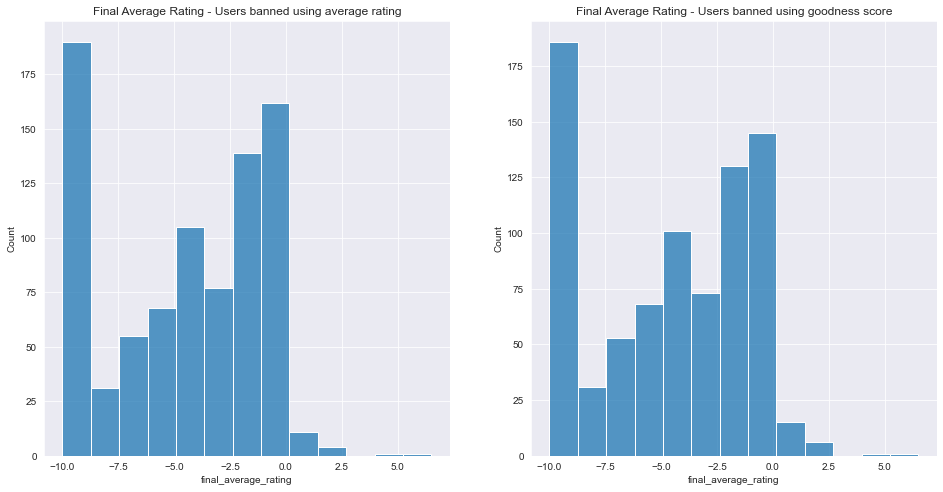

In [202]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
sb.histplot(data=users_banned_average, x='final_average_rating')
plt.title('Final Average Rating - Users banned using average rating')
plt.subplot(122)
sb.histplot(data=users_banned_goodness, x='final_average_rating')
plt.title('Final Average Rating - Users banned using goodness score')
plt.show()

### Ratings of the In-Edges Removed

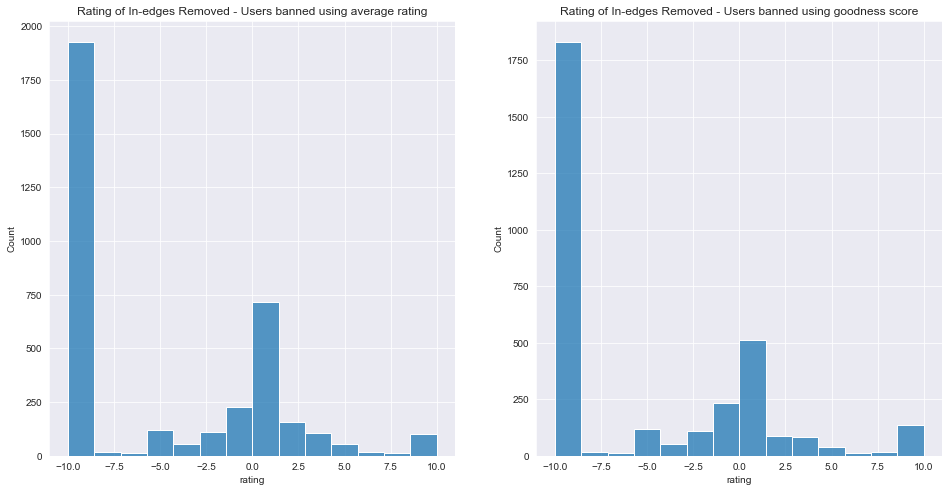

In [138]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
sb.histplot(data=in_edges_removed_average, x='rating')
plt.title('Rating of In-edges Removed - Users banned using average rating')
plt.subplot(122)
sb.histplot(data=in_edges_removed_goodness, x='rating')
plt.title('Rating of In-edges Removed - Users banned using goodness score')
plt.show()

### Ratings of Out-Edges Removed

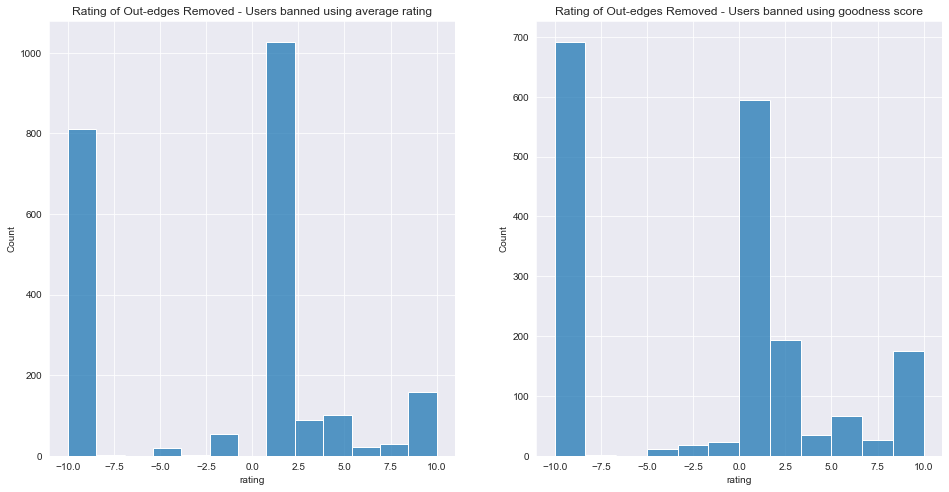

In [139]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
sb.histplot(data=out_edges_removed_average, x='rating')
plt.title('Rating of Out-edges Removed - Users banned using average rating')
plt.subplot(122)
sb.histplot(data=out_edges_removed_goodness, x='rating')
plt.title('Rating of Out-edges Removed - Users banned using goodness score')
plt.show()